In [ ]:
import mnist_loader
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dane_treningowe, dane_walidacyjne, dane_testowe = mnist_loader.load_data_wrapper()

W danych treningowych y to jest liczba, natomiast w danych testowych y to wektor długości 10

Dlatego zmieniamy to w pliku `mnist_loader.py` aby w obu przypadkach mieć wektor długości 10

In [3]:
dane_treningowe = list(dane_treningowe)
dane_walidacyjne = list(dane_walidacyjne)
dane_testowe = list(dane_testowe)

print(len(dane_treningowe)) 
print(len(dane_walidacyjne))
print(len(dane_testowe)) 

50000
10000
10000


In [4]:
print(dane_treningowe[1][0].shape) # wymiar danych
print(dane_treningowe[1][1].shape) # wymiar etykiety
# Czyli mamy wektory kolumnowe

# Trzeba je przekonwertować na wierszowe

# Mozna to zmienić w load_data_wrapper()
# Można też robić to w sieci (na razie ten wariant)

(784, 1)
(10, 1)


#### Definiujemy byty

* Warstwa, metody:
1. forward propagation
2. back propagation

 Warstwa powinna mieć atrybuty:
- wagi
- dane_na_wejsciu (zapamietać)
- dane_na_wyjsciu (przekazujemy)
- liczba neuronow
- funkcja aktywacji
- net (zapamiętać)

Zapamiętać np. w liście

* Sieć (składa sie z wielu Warstw), metody
1. forward prop - wykonujemy na każdej z warstw
2. backward prop - wykonujemy na każdej z warstw
3. fit
4. predict
5. dokladnosc

* Czy dobre byłoby także znormalizować dane, aby przyjmowały wartości z przedziału [0,1]?
 W ten sposób zminimalizujemy ryzyko liczenia gradientów o bardzo dużych wartościach. Pytanie czy wtedy trzeba generować dane z rozkladu $\mathcal{N}(0,1/\sqrt{n})$, n - liczba danych na wejściu
 Czy wystarczy $\mathcal{N}(0,1)$

 * Czy aktualizację wag lepiej jest robić w osobnej funkcji w klasie Warstwa, czy podczas back_prop?

In [6]:
def wygeneruj_wagi(wymiar_wejscie, wymiar_wyjscie):
    # wyjściem jest liczba neuronów w następnej warstwie
    wektor_wag = np.random.normal(0,1/math.sqrt(wymiar_wejscie),(1+wymiar_wejscie)*wymiar_wyjscie)
    return np.reshape(wektor_wag, (wymiar_wyjscie, 1+wymiar_wejscie )  )

# Definiujemy funkcje aktywacji fi (sigmoid)
# fi' = fi*(1-fi) 
def sigmoid(x): return (1+np.exp(-x))**(-1) 

def deriv_sigmoid(x): return sigmoid(x)*(1-sigmoid(x))

In [7]:
class SiecNeuronowa:
    def __init__(self, wymiary = [784, 128, 64, 10]):
        # definiujemy listę obiektów warstwy
        self.warstwy = list()
        # Może każdej warstwy definiujemy funkcję aktywacji? (W ten sposób można wykorzystać różne funkcje)

        for i in range(len(wymiary)-1):
            warstwa = Warstwa(wymiary[i+1], wymiary[i])
            self.warstwy.append(warstwa)

    def forward_propagation(self, X):
        wyjscie = X
        
        for warstwa in self.warstwy:
            wyjscie = warstwa.forward_prop(wyjscie)
        return wyjscie
            

    def backward_propagation(self):
        pass
        
    def fit(self):
        pass

    def predict(self):
        pass

    def dokladnosc(self):
        pass

class Warstwa:
    def __init__(self, liczba_neuronow, dane_wejscie):
        """liczba neuronów - w warstwie (czyli liczba danych na wyjściu)"""
        self.liczba_neuronow = liczba_neuronow

        self.dane_wejscie = dane_wejscie
        self.liczba_wejscie = len(self.dane_wejscie)
        # Ustalamy stałą uczenia dla całej warstwy
        self.stala_uczenia = 0.1

        # Inicjalizacja wag
        self.wagi = wygeneruj_wagi(self.dane_wejscie, self.liczba_neuronow)

        # Rzeczy do zapamiętania
        self.lista_dane_wejscie = list()
        self.lista_net = list()
    

    def fun_aktywacji(self, x): return sigmoid(x)

    def pochodna_fun_aktywacji(self, x): return deriv_sigmoid(x)

    def forward_prop(self, dane_wejscie ):
        """Definiujemy propagację w przód.
        Podajemy dane na wejście, dodajemy na bias = 1 na początek wektora (otrzymujemy w ten sposób X).
        Zadajemy najpierw ile chcemy mieć neuronów na wyjściu
        Nastepnie liczymy net = W*X <- wyjście netto.
        Póżniej nakładamy funkcję aktywacji fi na net, otrzymując fi(net) = a <- wyjście z warstwy.
        Musimy też zapisywać stany x, net, a dla każdej warstwy (np. listy)"""

        # Musimy przerobić X na wektor kolumnowy
        self.X = np.vstack([1, dane_wejscie.reshape(-1,1)])
        self.net = self.wagi @ self.X
        dane_wyjscie = self.fun_aktywacji(self.net)

        self.lista_net.append(self.net)
        self.lista_dane_wejscie.append(self.X)

        self.wyjscia_forward_prop = dane_wyjscie

        return dane_wyjscie
    
    def back_prop(self, wyjscie_oczekiwane):
        """Definiujemy propagację wstecz.
        W ostatniej warstwie liczymy funkcję straty, następnie pochodną dL/da."""
        
        # Funkcja straty to L = 1/2(a[L]-y)^2, czyli pochodna z L to a[L]-y
        dL_a = self.wyjscia_forward_prop - wyjscie_oczekiwane

        # mamy pochodną dL/da * fi(net)
        delta = dL_a * self.pochodna_fun_aktywacji( self.net )
        dL_dW = delta @ self.X.T

        # Liczymy dL/dX i usuwamy pierwszy element, otrzymując dL/da niższej warstwy
        dL_dX = self.wagi.T @ delta
        
        # Dane do przekazania warstwę niżej
        dL_a = dL_dX[1:]

        # Aktualizujemy wagi
        self.wagi = self.wagi - self.stala_uczenia * dL_dW

        return dL_a
    

In [8]:
x = np.array([1,0]).reshape(2,1)
y = np.array([0,1]).reshape(2,1)
W1 = np.array([[-0.1, -0.2, 0.1],
               [-0.4, 0.7, -0.6]])
W2 = np.array([[-0.15, -0.25, 0.15],
               [-0.45, 0.75, -0.65]])
X1 = np.vstack((1,x))


#### Lepiej będzie chyba podawać w `__init__` Warstwa liczbę danych na wejściu i liczbę neuronów

In [ ]:

class Warstwa:
    def __init__(self, liczba_wejscie, liczba_neuronow):
        """liczba neuronów - w warstwie (czyli liczba danych na wyjściu)"""
        self.liczba_neuronow = liczba_neuronow

        self.liczba_wejscie = liczba_wejscie
        
        # Ustalamy stałą uczenia dla całej warstwy
        self.stala_uczenia = 0.1

        # Inicjalizacja wag
        self.wagi = wygeneruj_wagi(self.liczba_wejscie, self.liczba_neuronow)
        print(f"wagi: {self.wagi.shape}")

        # Rzeczy do zapamiętania,
        #  Może wystarczy zapamiętać tylko ostatnie wartosci
        self.lista_dane_wejscie = list()
        self.lista_net = list()
        self.wyjscie_forward_prop = None
    

    def fun_aktywacji(self, x): return sigmoid(x)

    def pochodna_fun_aktywacji(self, x): return deriv_sigmoid(x)

    def forward_prop(self, dane_wejscie ):
        """Definiujemy propagację w przód.
        Podajemy dane na wejście, dodajemy na bias = 1 na początek wektora (otrzymujemy w ten sposób X).
        Zadajemy najpierw ile chcemy mieć neuronów na wyjściu
        Nastepnie liczymy net = W*X <- wyjście netto.
        Póżniej nakładamy funkcję aktywacji fi na net, otrzymując fi(net) = a <- wyjście z warstwy.
        Musimy też zapisywać stany x, net, a dla każdej warstwy (np. listy)"""

        # Musimy przerobić X na wektor kolumnowy
        self.X = np.vstack([1, dane_wejscie.reshape(-1,1)])
        self.net = self.wagi @ self.X
        dane_wyjscie = self.fun_aktywacji(self.net)

        self.lista_net.append(self.net)
        self.lista_dane_wejscie.append(self.X)

        self.wyjscie_forward_prop = dane_wyjscie

        return dane_wyjscie
    
    def back_prop(self, wyjscie_oczekiwane, czy_warstwa_wyjsciowa = False):
        """Definiujemy propagację wstecz.
        W ostatniej warstwie liczymy funkcję straty, następnie pochodną dL/da."""
        
        # Funkcja straty to L = 1/2(a[L]-y)^2, czyli pochodna z L to a[L]-y

        # Ten fragment chyba nie jest potrzeby
        dL_a = wyjscie_oczekiwane
        #dL_a = self.wyjscia_forward_prop - wyjscie_oczekiwane
        #print("dL_a")
        #print(dL_a)

        if czy_warstwa_wyjsciowa == True:
            dL_a = wyjscie_oczekiwane * self.pochodna_fun_aktywacji(self.net)
        else:
            wagi_bez_biasu = self.wagi[:, 1:] #pomijamy wagę dla biasu

        # mamy pochodną dL/da * fi(net)
        delta = dL_a * self.pochodna_fun_aktywacji( self.net )
        print("delta")
        print(delta)

        dL_dW = delta @ self.X.T
        print("dL_dW")
        print(dL_dW)

        # Liczymy dL/dX i usuwamy pierwszy element, otrzymując dL/da niższej warstwy
        dL_dX = self.wagi.T @ delta
        
        # Dane do przekazania warstwę niżej
        dL_a = dL_dX[1:]

        # Aktualizujemy wagi
        self.wagi = self.wagi - self.stala_uczenia * dL_dW

        return dL_a
    

class SiecNeuronowa:
    def __init__(self, wymiary = [784, 128, 64, 10]):
        # definiujemy listę obiektów warstwy
        self.warstwy = list()
        # Może każdej warstwy definiujemy funkcję aktywacji? (W ten sposób można wykorzystać różne funkcje)

        for i in range(len(wymiary)-1):
            warstwa = Warstwa(wymiary[i], wymiary[i+1]) # Liczba na wejście i na wyjście
            self.warstwy.append(warstwa)

    def forward_propagation(self, X):
        wyjscie = X
        
        for warstwa in self.warstwy:
            wyjscie = warstwa.forward_prop(wyjscie)
            print("wyjscie z warstwy")
            print(wyjscie)
        return wyjscie
            

    def backward_propagation(self, y):

        ostatnie_wyjscie = self.warstwy[-1].wyjscia_forward_prop

        dL_da = ostatnie_wyjscie - y

        for i in range(len(self.warstwy) - 1, -1, -1):
            dL_da = self.warstwy[i].back_prop(dL_da)
        # Pytanie czy musi tu być niższe dL_da, czy podmieniamy obecne?
        return dL_da
    
    def krok_uczenia(self, X, y):
        """Definiujemy pętlę dla jednej epoki"""

        # Forward prop
        y_estymowany = self.forward_propagation(X)

        # Strata
        strata = np.mean((y_estymowany - y)**2)

        # Back prop
        self.backward_propagation(y)

        return strata # zwracamy wartośc funkcji straty

    def fit(self, X, y, epoki = 10):
        """Przeprowadzamy fit() dla wielu epok"""

        for epoka in range(epoki):

            strata_w_epoce = 0
            
            # W każdej epoce "mieszamy" dane
            # W tym celu "mieszamy" indeksy
            indeksy = np.random.permutation(len(X))
            X_tasowane = X[indeksy]
            y_tasowane = y[indeksy]


        pass


    def predict(self):
        pass

    def dokladnosc(self):
        pass




### Wersja pod mini-batch'e - gotowa

In [37]:
def wygeneruj_wagi(wymiar_wejscie, wymiar_wyjscie):
    # wyjściem jest liczba neuronów w następnej warstwie
    wektor_wag = np.random.normal(0,1/math.sqrt(wymiar_wejscie),(1+wymiar_wejscie)*wymiar_wyjscie)
    return np.reshape(wektor_wag, (wymiar_wyjscie, 1+wymiar_wejscie )  )

# Definiujemy funkcje aktywacji fi (sigmoid)
# fi' = fi*(1-fi) 
def sigmoid(x): return (1+np.exp(-x))**(-1) 

def deriv_sigmoid(x): return sigmoid(x)*(1-sigmoid(x))


class Warstwa:
    def __init__(self, liczba_wejscie, liczba_neuronow):
        """liczba neuronów - w warstwie (czyli liczba danych na wyjściu)"""
        self.liczba_neuronow = liczba_neuronow

        self.liczba_wejscie = liczba_wejscie
        
        # Ustalamy stałą uczenia dla całej warstwy
        self.stala_uczenia = 0.1

        # Inicjalizacja wag
        self.wagi = wygeneruj_wagi(self.liczba_wejscie, self.liczba_neuronow)

        # Rzeczy do zapamiętania,
        #  Może wystarczy zapamiętać tylko ostatnie wartosci
        self.lista_dane_wejscie = list()
        self.lista_net = list()
    

    def fun_aktywacji(self, x): return sigmoid(x)

    def pochodna_fun_aktywacji(self, x): return deriv_sigmoid(x)

    def forward_prop(self, dane_wejscie ):
        """Definiujemy propagację w przód.
        Podajemy dane na wejście, dodajemy na bias = 1 na początek wektora (otrzymujemy w ten sposób X).
        Zadajemy najpierw ile chcemy mieć neuronów na wyjściu
        Nastepnie liczymy net = W*X <- wyjście netto.
        Póżniej nakładamy funkcję aktywacji fi na net, otrzymując fi(net) = a <- wyjście z warstwy.
        Musimy też zapisywać stany x, net, a dla każdej warstwy (np. listy)"""
        
        rozmiar_batcha = dane_wejscie.shape[1]
        biasy = np.ones((1, rozmiar_batcha))

        self.X = np.vstack([biasy, dane_wejscie]) # Dodajemy biasy

        self.net = self.wagi @ self.X

        dane_wyjscie = self.fun_aktywacji(self.net)

        self.lista_net.append(self.net)
        self.lista_dane_wejscie.append(self.X)

        self.wyjscia_forward_prop = dane_wyjscie

        return dane_wyjscie
    
    def back_prop(self, dL_a):
        """Definiujemy propagację wstecz.
        W ostatniej warstwie liczymy funkcję straty, następnie pochodną dL/da."""
        
        # Funkcja straty to L = 1/2(a[L]-y)^2, czyli pochodna z L to a[L]-y

        # mamy pochodną dL/da * fi(net)
        delta = dL_a * self.pochodna_fun_aktywacji( self.net )
        dL_dW = delta @ self.X.T

        # Liczymy dL/dX i usuwamy pierwszy element, otrzymując dL/da niższej warstwy
        dL_dX = self.wagi.T @ delta
        
        # Dane do przekazania warstwę niżej
        dL_a = dL_dX[1:]

        # Aktualizujemy wagi
        self.wagi = self.wagi - self.stala_uczenia * dL_dW

        return dL_a
    

class SiecNeuronowa:
    def __init__(self, wymiary = [784, 128, 64, 10]):

        # definiujemy listę obiektów warstwy
        self.warstwy = list()
        # Może każdej warstwy definiujemy funkcję aktywacji? (W ten sposób można wykorzystać różne funkcje)

        for i in range(len(wymiary)-1):
            warstwa = Warstwa(wymiary[i], wymiary[i+1]) # Liczba na wejście i na wyjście
            self.warstwy.append(warstwa)

    def forward_propagation(self, X):
        wejscie = X
        
        for warstwa in self.warstwy:
            wejscie = warstwa.forward_prop(wejscie)

        return wejscie
            

    def backward_propagation(self, y):

        ostatnie_wyjscie = self.warstwy[-1].wyjscia_forward_prop

        dL_da = ostatnie_wyjscie - y

        for i in range(len(self.warstwy) - 1, -1, -1):
            dL_da = self.warstwy[i].back_prop(dL_da)

        return dL_da
    
    def krok_uczenia(self, X, y):
        """Definiujemy kroki dla jednej epoki"""

        # Forward prop
        y_estymowany = self.forward_propagation(X)

        # Strata
        strata = np.mean((y_estymowany - y)**2)

        # Back prop
        self.backward_propagation(y)

        return strata # zwracamy wartośc funkcji straty

    def fit(self, dane_w_krotkach, epoki = 10, rozmiar_batcha = 32):
        """Przeprowadzamy fit() dla wielu epok"""

        straty = list()

        for epoka in range(epoki):

            strata_w_epoce = 0
            liczba_batchy = 0

            # W każdej epoce "mieszamy" dane
            np.random.shuffle(dane_w_krotkach)

            # dzielimy zbiór danych na porcje
            for i in range(0, len(dane_w_krotkach), rozmiar_batcha): 
                batch = dane_w_krotkach[i:i + rozmiar_batcha]

                # Wyciągamy z krotki osobno X i y
                X_batch = np.hstack([x for x, y in batch])
                y_batch = np.hstack([y for x, y in batch])
                

                # Strata (oraz wykonanie forward prop i back prop)
                strata = self.krok_uczenia(X_batch, y_batch)
                strata_w_epoce += strata
                liczba_batchy +=1
            
            srednia_strata = strata_w_epoce/liczba_batchy
            straty.append(srednia_strata)

            
        return straty

    def predict(self, X):
        return self.forward_propagation(X)

    def dokladnosc(self, dane):
        """ Oblicza dokładność klasyfikacji"""
        poprawne = 0
        liczba_danych = len(dane)

        for x, y in dane:

            # Z y daną cyfrę
            y_prawdziwe = np.argmax(y)

            przewidywane = self.predict(x)
            # Wybieramy z wektora argument o najwyższej wartości
            y_przewidywane = np.argmax(przewidywane)

            # Sprawdzamy czy sieć dopasowałą poprawnie etykietę
            if y_prawdziwe == y_przewidywane:
                poprawne +=1
        # Zwracamy dokładność
        return poprawne/liczba_danych
            
def trenuj_siec():
    dane_treningowe, dane_walidacyjne, dane_testowe = mnist_loader.load_data_wrapper()
    # Pomijamy dane walidacyjne
    dane_treningowe = list(dane_treningowe)
    dane_testowe = list(dane_testowe)

    # Tworzymy sieć
    siec = SiecNeuronowa([784,256,128,64,10])

    print("Trening")
    historia = siec.fit(dane_treningowe, epoki= 20, rozmiar_batcha= 32)

    dokladnosc_trening = siec.dokladnosc(dane_treningowe)
    dokladnosc_test = siec.dokladnosc(dane_testowe)

    print(f"Dokładność na zbiorze treningowym: {dokladnosc_trening:.4f}")
    print(f"Dokładność na zbiorze testowym: {dokladnosc_test:.4f}")

    return siec, historia

In [38]:
siec, historia = trenuj_siec()

Trening
Dokładność na zbiorze treningowym: 0.9919
Dokładność na zbiorze testowym: 0.9778


Mamy dobre wyniki dla:
* warstwy = [784,128,64,10], epoki = 5, rozmiar batcha = 32, stała uczenia = 0.1
* warstwy = [784,128,64,32,10], epoki = 20, rozmiar batcha = 128, stała uczenia = 0.1

Ogólne wnioski:
* [784,256,64,10] np. dla takiej sieci wyniki są słabe, po 10*, nawet dla 20 epok

Text(0.5, 0, 'Epoki')

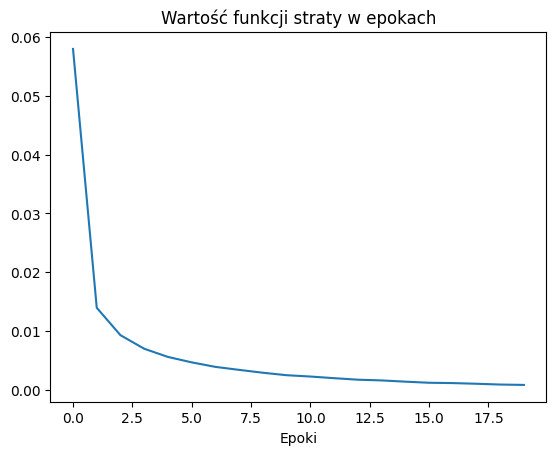

In [39]:
plt.plot(historia)
plt.title("Wartość funkcji straty w epokach")
plt.xlabel("Epoki")

### Empiryczne sprawdzenie, czy Warstwa jest poprawnie zaimplementowana

In [13]:
x = np.array([1,0]).reshape(2,1)
y = np.array([0,1]).reshape(2,1)
W1 = np.array([[-0.1, -0.2, 0.1],
               [-0.4, 0.7, -0.6]])
W2 = np.array([[-0.15, -0.25, 0.15],
               [-0.45, 0.75, -0.65]])
X1 = np.vstack((1,x))

warstwa1 = Warstwa(2,2)
warstwa1.wagi = W1
print("a[1]")
print(warstwa1.forward_prop(x)) # dostajemy a[1] z przykładu ML_06
a1 = warstwa1.forward_prop(x)


warstwa2 = Warstwa(2,2)
warstwa2.wagi = W2
#print(warstwa2.wagi)
a2 = warstwa2.forward_prop(a1)
print("a[2]")
print(a2)

# Czyli forward_prop działa
# Sprawdźmy back_prop

#w back_prop podajemy dL_da[k], otrzymując w ten sposób dL_da[k-1] z niższej warstwy (w międzyczasie aktualizujemy wagi)
dL_da2 = a2 - y
print("dL_da2")
print(dL_da2)
print()

dL_da1 = warstwa2.back_prop(dL_da2)
print("dL_da1")
print(dL_da1)
warstwa2.lista_net #mamy net1

print("nowe_wagi dla warstwy 2")
print(warstwa2.wagi)
############################## Kolejna warstwa ##########################

print("Obliczenia dla warstwy niżej")
print()

dL_da0 = warstwa1.back_prop(dL_da1)
print("dL_da0")
print(dL_da0)

print("nowe wagi dla warstwy 1")
print(warstwa1.wagi)
# Zwraca poprawne wyniki
# Czyli forward i back prop są dobrze zdefiniowane


wagi: (2, 3)
a[1]
dane_wejscie.shape (2, 1)
self.X.shape (3, 1)
wagi (2, 3)
self.X.shape (2, 1)
dane_wyjscie (2, 1)
[[0.42555748]
 [0.57444252]]
dane_wejscie.shape (2, 1)
self.X.shape (3, 1)
wagi (2, 3)
self.X.shape (2, 1)
dane_wyjscie (2, 1)
wagi: (2, 3)
dane_wejscie.shape (2, 1)
self.X.shape (3, 1)
wagi (2, 3)
self.X.shape (2, 1)
dane_wyjscie (2, 1)
a[2]
[[0.45754671]
 [0.37654958]]
dL_da2
[[ 0.45754671]
 [-0.62345042]]

delta
[[ 0.11356205]
 [-0.14636122]]
dL_dW
[[ 0.11356205  0.04832718  0.06523487]
 [-0.14636122 -0.06228511 -0.08407611]]
dL_da1
[[-0.13816143]
 [ 0.1121691 ]]
nowe_wagi dla warstwy 2
[[-0.16135621 -0.25483272  0.14347651]
 [-0.43536388  0.75622851 -0.64159239]]
Obliczenia dla warstwy niżej

delta
[[-0.03377471]
 [ 0.02742067]]
dL_dW
[[-0.03377471 -0.03377471  0.        ]
 [ 0.02742067  0.02742067  0.        ]]
dL_da0
[[ 0.02594941]
 [-0.01982987]]
nowe wagi dla warstwy 1
[[-0.09662253 -0.19662253  0.1       ]
 [-0.40274207  0.69725793 -0.6       ]]


Możemy ulepszyć tę sieć dodając np:
* Osobną funkcję aktywacji dla każdej warsty np ReLU
* 

In [14]:
siec = SiecNeuronowa(wymiary=[2,2,2])
siec.warstwy[0] = warstwa1
siec.warstwy[1] = warstwa2

#siec.forward_propagation(x)
#siec.backward_propagation(dL_da2)

wagi: (2, 3)
wagi: (2, 3)


In [15]:
A = np.array([[1,2],[3,4]])
A

array([[1, 2],
       [3, 4]])

In [16]:
A_kolumnowy = A.reshape(-1,1) # kolumnowy
A_wierszowy = A.reshape(1,-1) 
print(A_kolumnowy.shape)
print(A_wierszowy.shape)
print(A_wierszowy)

(4, 1)
(1, 4)
[[1 2 3 4]]


In [56]:
b = np.ones((4,1))
print(b)
polaczone = np.hstack([b,A_kolumnowy])
polaczone.shape

[[1.]
 [1.]
 [1.]
 [1.]]


(4, 2)

# Wersja z zadawaniem funkcji aktywacji dla warstwy

In [125]:
def wygeneruj_wagi(wymiar_wejscie, wymiar_wyjscie):
    # wyjściem jest liczba neuronów w następnej warstwie
    wektor_wag = np.random.normal(0,1/math.sqrt(wymiar_wejscie),(1+wymiar_wejscie)*wymiar_wyjscie)
    return np.reshape(wektor_wag, (wymiar_wyjscie, 1+wymiar_wejscie )  )

# Definiujemy funkcje aktywacji fi (sigmoid)
# fi' = fi*(1-fi) 
def sigmoid(x): return (1+np.exp(-x))**(-1) 

def deriv_sigmoid(x): return sigmoid(x)*(1-sigmoid(x))

# Definiujemy funkcję aktywacji ReLU
def relu(x): return np.maximum(0,x) # maximum zwraca macierz

def deriv_relu(x): return np.where(x>0, 1,0)


class Warstwa:
    def __init__(self, liczba_wejscie, liczba_neuronow, funkcja_aktywacji = "sigmoid"):
        """liczba neuronów - w warstwie (czyli liczba danych na wyjściu)"""
        self.liczba_neuronow = liczba_neuronow

        self.liczba_wejscie = liczba_wejscie
        
        # Ustalamy stałą uczenia dla całej warstwy
        self.stala_uczenia = 0.03

        # Inicjalizacja wag
        self.wagi = wygeneruj_wagi(self.liczba_wejscie, self.liczba_neuronow)
        
        # Funkcja aktywacji, która będzie wykorzystana w danej warstwie
        self.funkcja_aktywacji = funkcja_aktywacji

        # Rzeczy do zapamiętania,
        #  Może wystarczy zapamiętać tylko ostatnie wartosci
        self.lista_dane_wejscie = list()
        self.lista_net = list()
    

    def fun_aktywacji(self, x): 
        if self.funkcja_aktywacji == "sigmoid": 
            return sigmoid(x)
        elif self.funkcja_aktywacji == "relu": 
            return relu(x)

    def pochodna_fun_aktywacji(self, x):
        if self.funkcja_aktywacji == "sigmoid": 
            return deriv_sigmoid(x)
        elif self.funkcja_aktywacji == "relu": 
            return deriv_relu(x)

    def forward_prop(self, dane_wejscie ):
        """Definiujemy propagację w przód.
        Podajemy dane na wejście, dodajemy na bias = 1 na początek wektora (otrzymujemy w ten sposób X).
        Zadajemy najpierw ile chcemy mieć neuronów na wyjściu
        Nastepnie liczymy net = W*X <- wyjście netto.
        Póżniej nakładamy funkcję aktywacji fi na net, otrzymując fi(net) = a <- wyjście z warstwy.
        Musimy też zapisywać stany x, net, a dla każdej warstwy (np. listy)"""
        
        rozmiar_batcha = dane_wejscie.shape[1]
        biasy = np.ones((1, rozmiar_batcha))

        self.X = np.vstack([biasy, dane_wejscie]) # Dodajemy biasy

        self.net = self.wagi @ self.X

        dane_wyjscie = self.fun_aktywacji(self.net)

        self.lista_net.append(self.net)
        self.lista_dane_wejscie.append(self.X)

        self.wyjscia_forward_prop = dane_wyjscie

        return dane_wyjscie
    
    def back_prop(self, dL_a):
        """Definiujemy propagację wstecz.
        W ostatniej warstwie liczymy funkcję straty, następnie pochodną dL/da."""
        
        # Funkcja straty to L = 1/2(a[L]-y)^2, czyli pochodna z L to a[L]-y

        # mamy pochodną dL/da * fi(net)
        delta = dL_a * self.pochodna_fun_aktywacji( self.net )
        dL_dW = delta @ self.X.T

        # Liczymy dL/dX i usuwamy pierwszy element, otrzymując dL/da niższej warstwy
        dL_dX = self.wagi.T @ delta
        
        # Dane do przekazania warstwę niżej
        dL_a = dL_dX[1:]

        # Aktualizujemy wagi
        self.wagi = self.wagi - self.stala_uczenia * dL_dW

        return dL_a
    

class SiecNeuronowa:
    def __init__(self, wymiary = [784, 128, 64, 10], funkcje_aktywacji=None):

        # Definiujemy domyślne funkcje aktywacji dla warstw (np. sigmoid)
        if funkcje_aktywacji == None:
            funkcje_aktywacji = ["sigmoid"]*(len(wymiary)-1)

        # definiujemy listę obiektów warstwy
        self.warstwy = list()
        # Może każdej warstwy definiujemy funkcję aktywacji? (W ten sposób można wykorzystać różne funkcje)

        for i in range(len(wymiary)-1):
            warstwa = Warstwa(wymiary[i], wymiary[i+1], funkcje_aktywacji[i]) # Liczba na wejście i na wyjście
            self.warstwy.append(warstwa)
            print(f"Warstwa {i}: {wymiary[i]} -> {wymiary[i+1]}, funkcja {funkcje_aktywacji[i]}")

    def forward_propagation(self, X):
        wejscie = X
        
        for warstwa in self.warstwy:
            wejscie = warstwa.forward_prop(wejscie)

        return wejscie
            

    def backward_propagation(self, y):

        ostatnie_wyjscie = self.warstwy[-1].wyjscia_forward_prop

        dL_da = ostatnie_wyjscie - y

        for i in range(len(self.warstwy) - 1, -1, -1):
            dL_da = self.warstwy[i].back_prop(dL_da)

        return dL_da
    
    def krok_uczenia(self, X, y):
        """Definiujemy kroki dla jednej epoki"""

        # Forward prop
        y_estymowany = self.forward_propagation(X)

        # Strata
        strata = np.mean((y_estymowany - y)**2)

        # Back prop
        self.backward_propagation(y)

        return strata # zwracamy wartośc funkcji straty

    def fit(self, dane_w_krotkach, epoki = 10, rozmiar_batcha = 32):
        """Przeprowadzamy fit() dla wielu epok"""

        straty = list()

        for epoka in range(epoki):

            strata_w_epoce = 0
            liczba_batchy = 0

            # W każdej epoce "mieszamy" dane
            np.random.shuffle(dane_w_krotkach)

            # dzielimy zbiór danych na porcje
            for i in range(0, len(dane_w_krotkach), rozmiar_batcha): 
                batch = dane_w_krotkach[i:i + rozmiar_batcha]

                # Wyciągamy z krotki osobno X i y
                X_batch = np.hstack([x for x, y in batch])
                y_batch = np.hstack([y for x, y in batch])
                

                # Strata (oraz wykonanie forward prop i back prop)
                strata = self.krok_uczenia(X_batch, y_batch)
                strata_w_epoce += strata
                liczba_batchy +=1
            
            srednia_strata = strata_w_epoce/liczba_batchy
            straty.append(srednia_strata)

            
        return straty

    def predict(self, X):
        return self.forward_propagation(X)

    def dokladnosc(self, dane):
        """ Oblicza dokładność klasyfikacji"""
        poprawne = 0
        liczba_danych = len(dane)

        for x, y in dane:

            # Z y daną cyfrę
            y_prawdziwe = np.argmax(y)

            przewidywane = self.predict(x)
            # Wybieramy z wektora argument o najwyższej wartości
            y_przewidywane = np.argmax(przewidywane)

            # Sprawdzamy czy sieć dopasowałą poprawnie etykietę
            if y_prawdziwe == y_przewidywane:
                poprawne +=1
        # Zwracamy dokładność
        return poprawne/liczba_danych
            
def trenuj_siec():
    dane_treningowe, dane_walidacyjne, dane_testowe = mnist_loader.load_data_wrapper()
    # Pomijamy dane walidacyjne
    dane_treningowe = list(dane_treningowe)
    dane_testowe = list(dane_testowe)

    # Tworzymy sieć
    fun_akt_sig = ["sigmoid","sigmoid","sigmoid","sigmoid"]
    fun_akt_relu_sig = ["relu","relu","sigmoid"]
    fun_akt_relu = ["relu","relu","relu"]
    siec = SiecNeuronowa([784,128,64,10], funkcje_aktywacji=fun_akt_sig)

    print("Trening")
    historia = siec.fit(dane_treningowe, epoki= 10, rozmiar_batcha= 100)

    dokladnosc_trening = siec.dokladnosc(dane_treningowe)
    dokladnosc_test = siec.dokladnosc(dane_testowe)

    print(f"Dokładność na zbiorze treningowym: {100*dokladnosc_trening:.4f} %")
    print(f"Dokładność na zbiorze testowym: {100*dokladnosc_test:.4f} %")

    return siec, historia

In [126]:
siec, historia = trenuj_siec()

Warstwa 0: 784 -> 128, funkcja sigmoid
Warstwa 1: 128 -> 64, funkcja sigmoid
Warstwa 2: 64 -> 10, funkcja sigmoid
Trening
Dokładność na zbiorze treningowym: 96.9440 %
Dokładność na zbiorze testowym: 96.2500 %


Text(0.5, 0, 'Epoki')

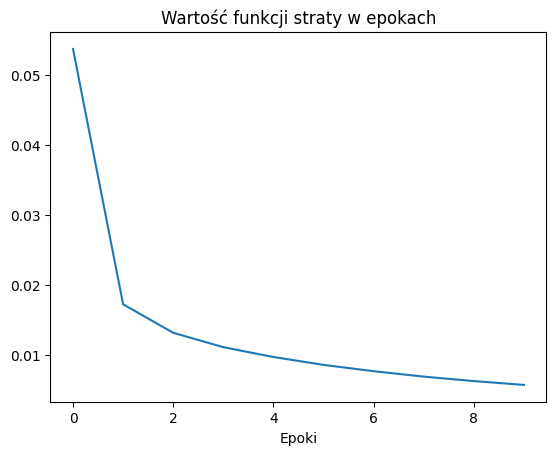

In [127]:
plt.plot(historia)
plt.title("Wartość funkcji straty w epokach")
plt.xlabel("Epoki")

Mamy dobre wyniki dla:
* warstwy = [784,128,64,10], epoki = 5, rozmiar batcha = 32, stała uczenia = 0.1
* warstwy = [784,128,64,32,10], epoki = 20, rozmiar batcha = 128, stała uczenia = 0.1

Ogólne wnioski:
* [784,256,64,10] np. dla takiej sieci wyniki są słabe, po 10*, nawet dla 20 epok
* ReLU na ostatniej warstwie znacznie pogarsza wynik, co było spodziewane. Wyniki Softmax i Sigmoid możemy traktować jak prawdopodobieństwa (przymują wartości z zakresu (0,1)), zatem są lepsze w przypadku ostatniej warstwy.